In [26]:
import pickle
import sys
from collections import defaultdict
from pathlib import Path

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
import seaborn as sns
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
from skimage import measure, exposure
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from typing import List
import skimage
from matplotlib.patches import Circle

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [29]:
import utils as utils
from config import *

# Read data

In [5]:
pixel_features = data_meta / "pixel_intensity.csv"  # location of file
df = pd.read_csv(pixel_features)

In [6]:
df = df.iloc[:,-4:]
df.head()

,Location,X,Y,Id
0,10,18,1086,6
1,10,19,1086,6
2,10,19,1087,6
3,10,19,1088,6
4,10,20,1085,6


In [38]:
with open(data_meta / f"kmeans_labels.pickle", "rb") as f:
    c_labels, pixels_bright_o = pickle.load(f)

In [39]:
len(c_labels)

54725214

In [40]:
pixels_bright_position = pixels_bright_o.join(df[["Location", "X", "Y", "Id"]])


In [41]:
df_subset = pixels_bright_position[pixels_bright_position.Location == 1]

In [42]:
df_subset

,p-EGFR,PCNA,APC,DKK1,Non-p-B-catenin,Cyclin E,EMMPRIN,Wnt1,RNF 43,p-AKT,...,EGFR,B-tubin,Cyclin D1,H3k27me3-488,H3k4me3-647,H3k9Ac-555,Location,X,Y,Id
11702746,0.000000,0.105516,0.000000,0.065309,0.000000,0.033143,0.050278,0.077806,0.121401,0.000000,...,0.281239,0.020142,0.041444,0.000000,0.012131,0.155688,1,12,291,7
11702749,0.018647,0.137423,0.000000,0.044388,0.000000,0.000000,0.033753,0.021363,0.167697,0.000000,...,0.318013,0.136278,0.069459,0.000000,0.023453,0.059373,1,12,294,7
11702752,0.000000,0.099382,0.000000,0.097642,0.019699,0.000000,0.044526,0.058564,0.000000,0.000000,...,0.121309,0.268711,0.057130,0.000000,0.015763,0.088319,1,12,297,7
11702754,0.000000,0.133730,0.000000,0.057069,0.032975,0.017319,0.000000,0.055146,0.239048,0.000000,...,0.150729,0.070054,0.125490,0.000000,0.020218,0.063859,1,12,299,7
11702755,0.000000,0.160723,0.000000,0.055802,0.017426,0.015442,0.000000,0.000000,0.103868,0.000000,...,0.454032,0.073884,0.021286,0.000000,0.024262,0.063371,1,12,300,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13077494,0.055329,0.204898,0.000000,0.013306,0.000000,0.000000,0.000000,0.000000,0.022522,0.000000,...,0.411765,0.187137,0.000000,0.000000,0.031128,0.000000,1,1399,233,43
13077496,0.006744,0.165637,0.007813,0.017121,0.000000,0.025803,0.000717,0.000000,0.051301,0.000000,...,0.351095,0.142992,0.004471,0.000000,0.000000,0.000000,1,1399,235,43
13077509,0.000000,0.099382,0.000000,0.105898,0.000000,0.005646,0.000000,0.000000,0.045045,0.027054,...,0.345586,0.111315,0.053773,0.000000,0.012131,0.042908,1,1400,227,43
13077513,0.000000,0.197543,0.000000,0.082429,0.000000,0.000000,0.000000,0.271901,0.420523,0.000000,...,0.198520,0.110353,0.000000,0.013504,0.021836,0.060365,1,1400,231,43


In [43]:
def create_image(pixels, df, mask, label2cluster=None):
    # Create image from pixel location
    x_max, y_max = mask.shape

    x = df.X.tolist()
    y = df.Y.tolist()
    
    img = np.zeros((x_max, y_max)) * np.nan
    img[x, y] = pixels
    return img


In [44]:
masks = utils.get_masks(data_mask)
mask, mask_nuclei, _ = utils.qc_nuclei(masks['1']["cyto"], masks['1']["nuclei"])

p-EGFR


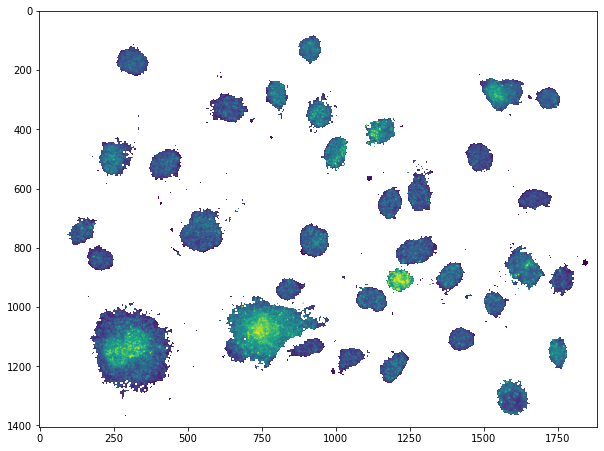

PCNA


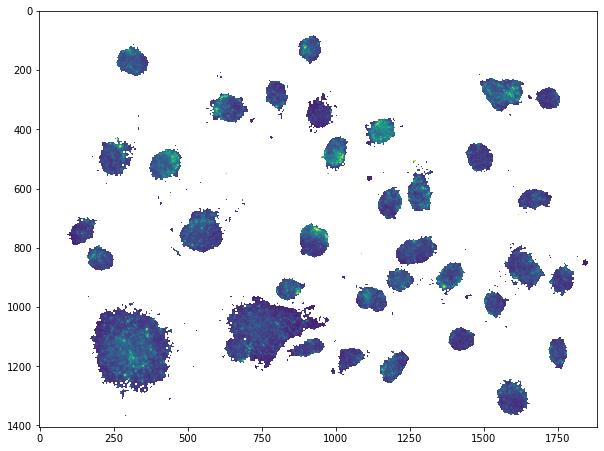

APC


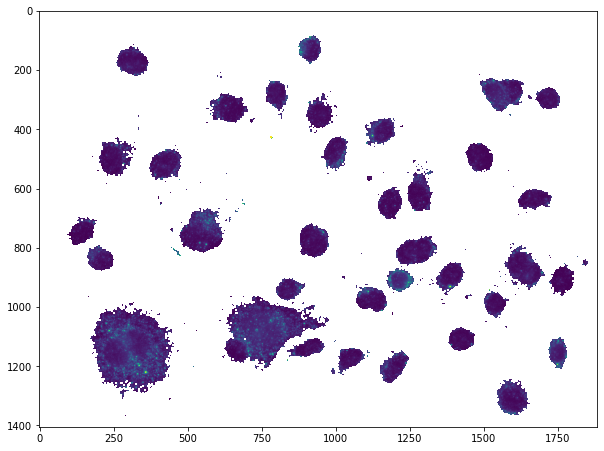

DKK1


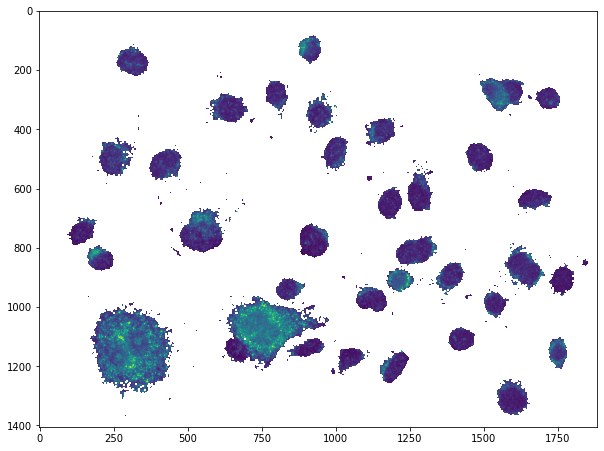

Non-p-B-catenin


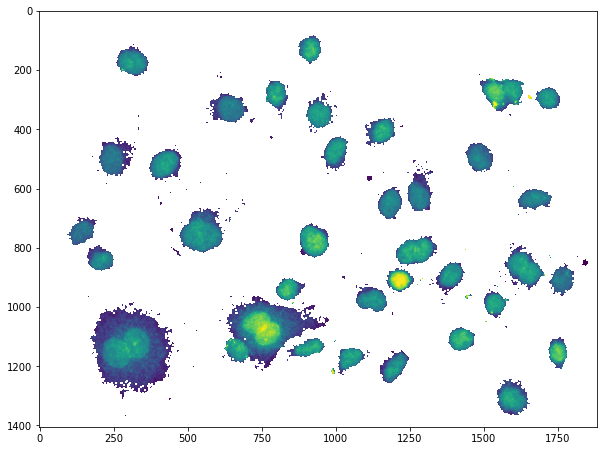

Cyclin E


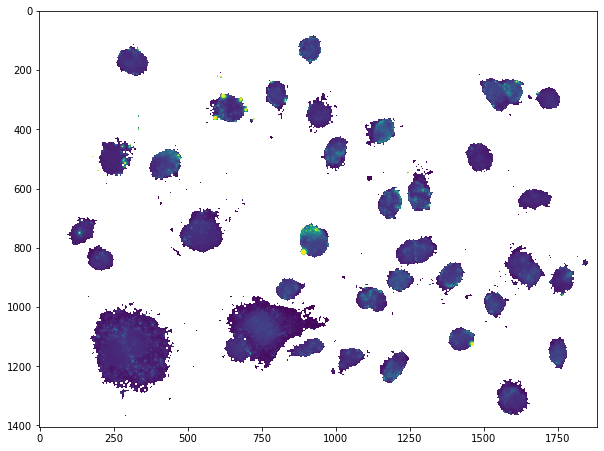

EMMPRIN


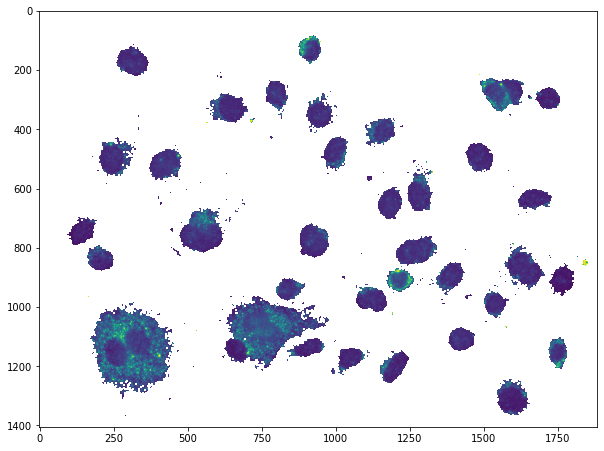

Wnt1


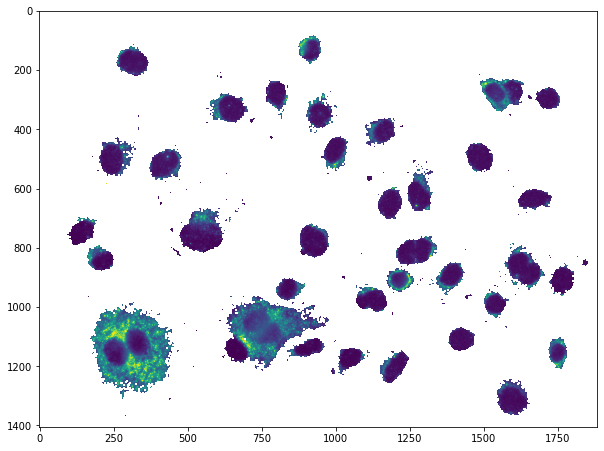

RNF 43


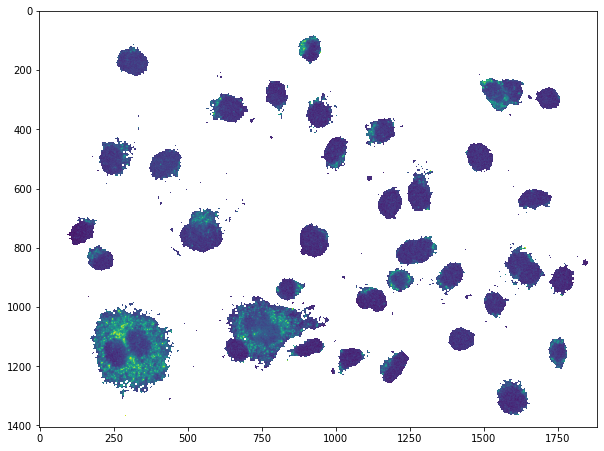

p-AKT


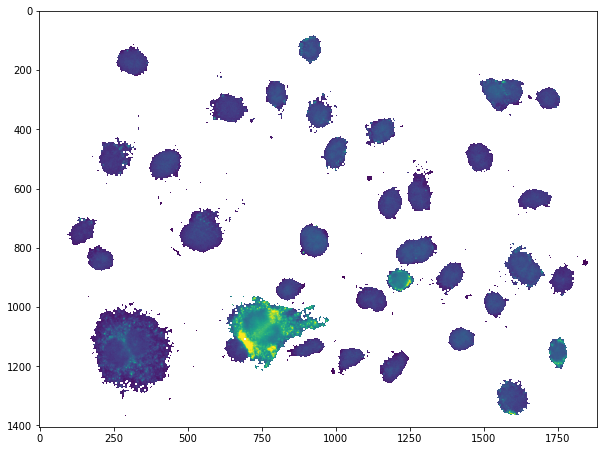

p-B-catenin


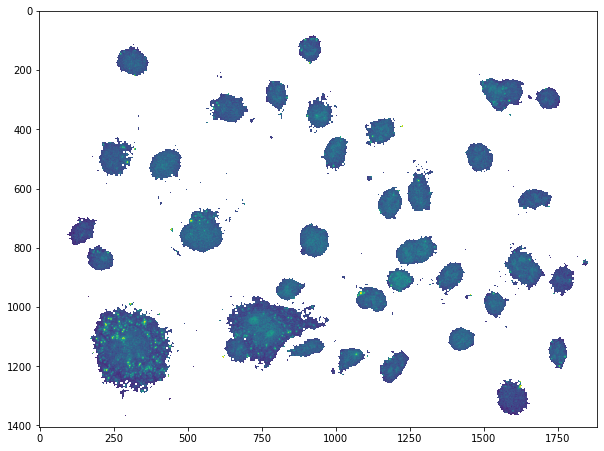

AKT


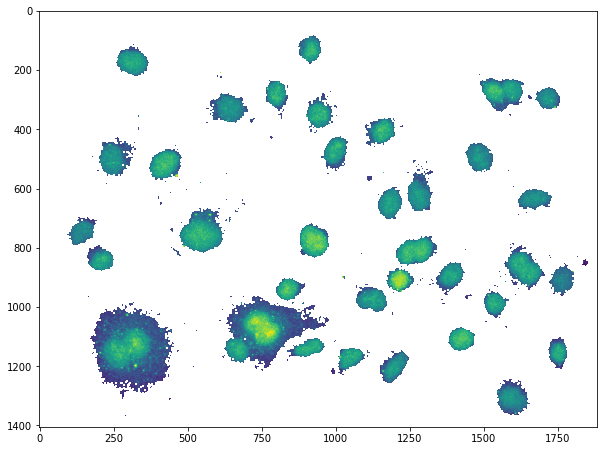

mTOR


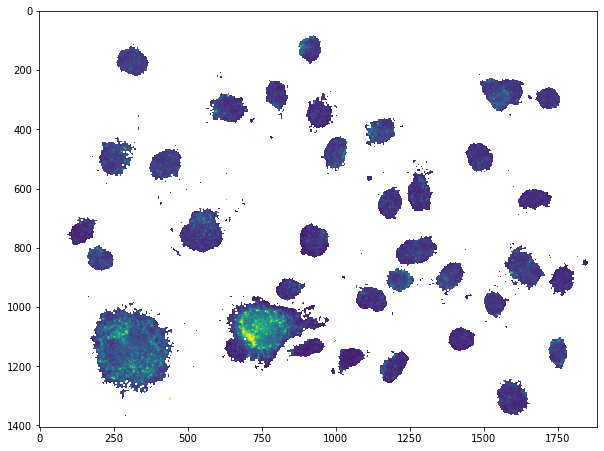

p-mTOR


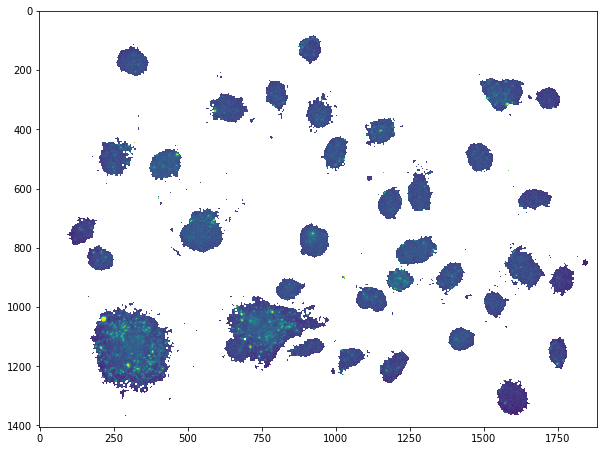

AXIN1


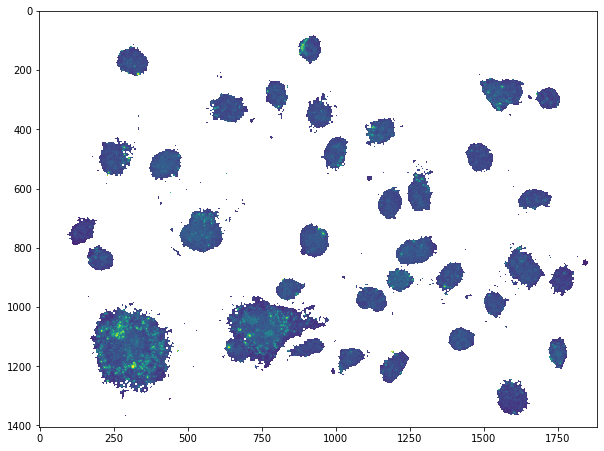

DKK2


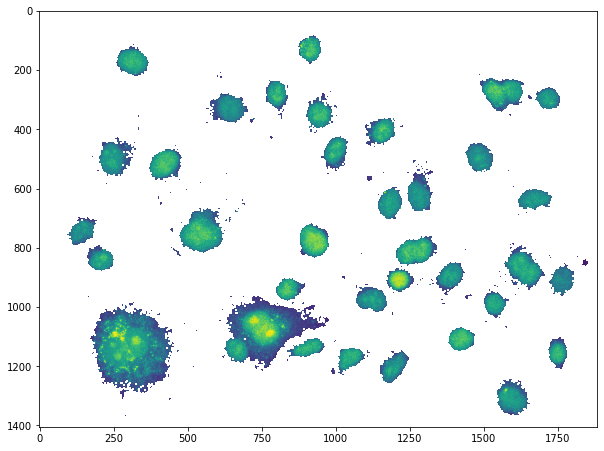

EGFR


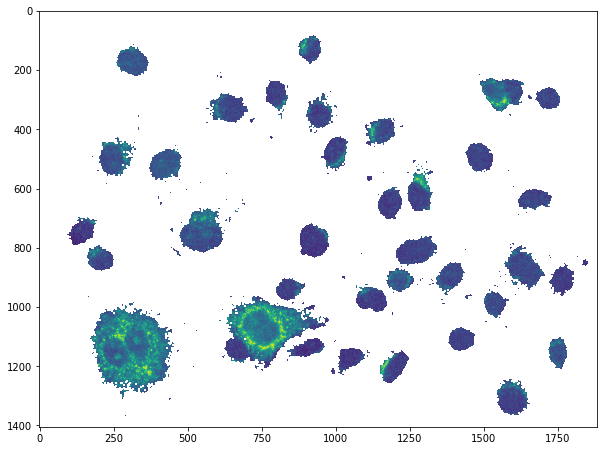

B-tubin


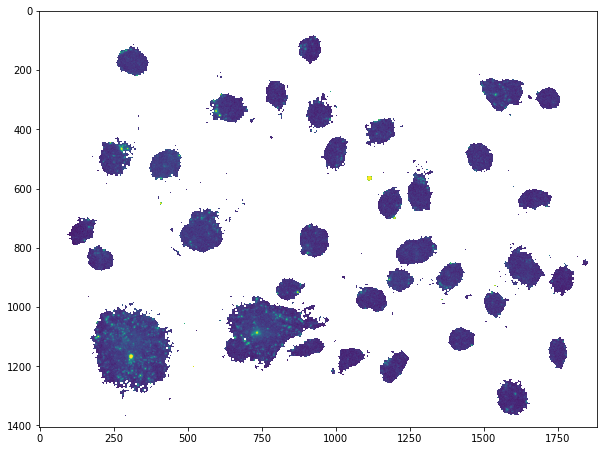

Cyclin D1


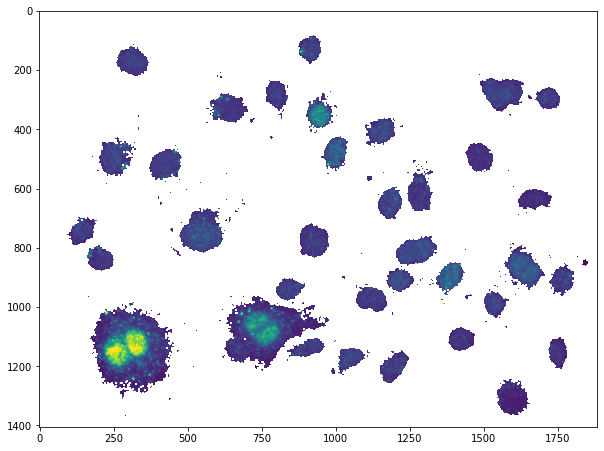

H3k27me3-488


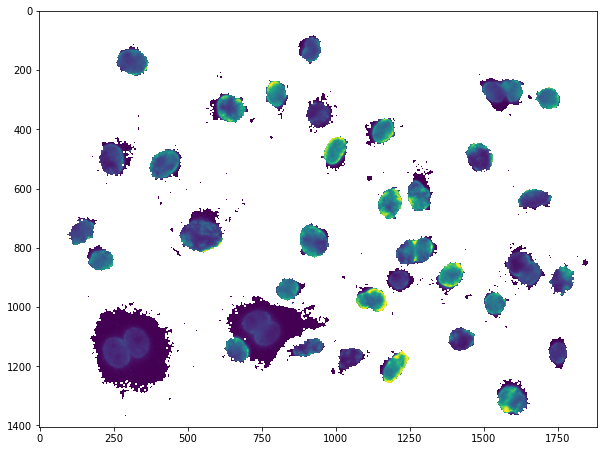

H3k4me3-647


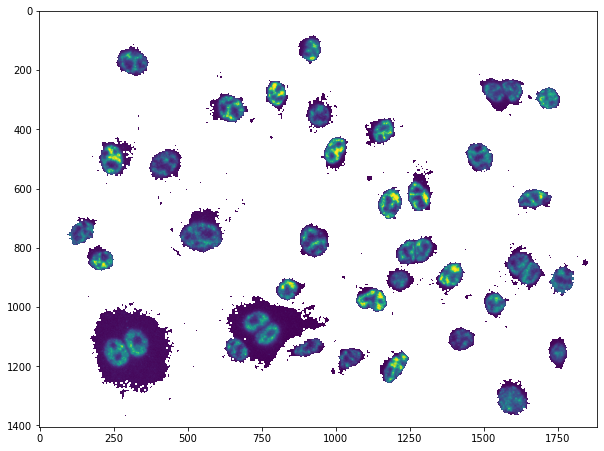

H3k9Ac-555


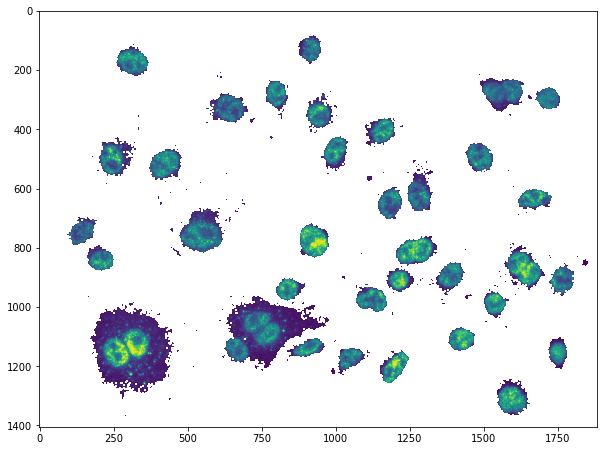

Location


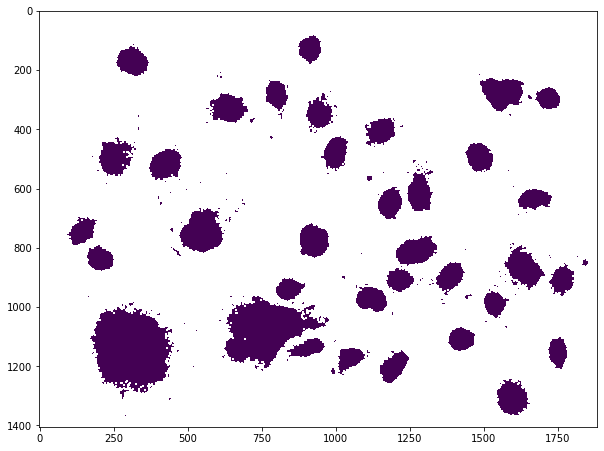

X


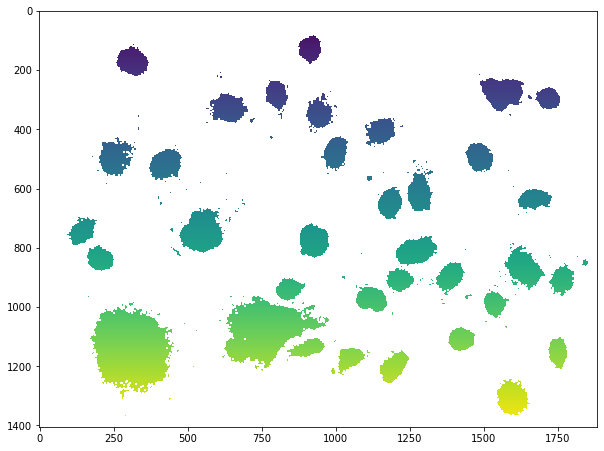

Y


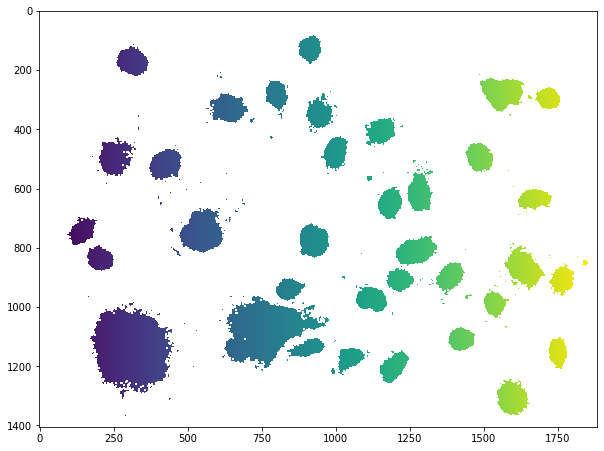

Id


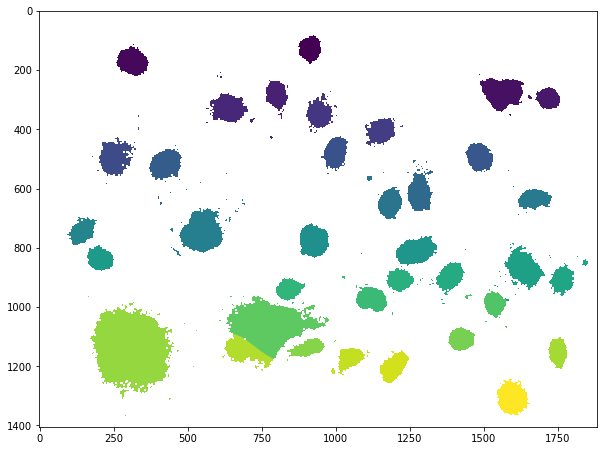

In [45]:
for marker  in df_subset.columns:
    print(marker)
    img = create_image(df_subset[marker].tolist(), df_subset,mask)
    fig, ax= plt.subplots(figsize=(10,10))
    ax.imshow(img)
    plt.show()